# Imports

In [1]:
import sys, os

from math import log10
from numpy import array, pi

import pandas as pd
import numpy as np
from numpy import concatenate
from bisect import bisect_left
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from hist import Hist
import hist

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import zero_one_loss, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.base import clone
# algorithms:
from sklearn.tree import export_graphviz, DecisionTreeClassifier#, plot_tree, export_text # Available in later versions
import graphviz

# Import data

In [14]:
import pandas as pd
import glob
import os

#if Helen 
#path = r"C:\Users\hpetr\Documents\University\Year 3\Bsc Project\Data"
#if Trinity
path = r"/Users/trinitystenhouse/Documents/University_MSci/2022-3/Project/Bsc-Project"

all_files = ["S2_only_AND_S1S2_Tritium.csv", "gate_data.csv", "gas_data.csv", "cathode_data.csv"]

li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)
df.keys()


Index(['target', 'type', 'runID', 'evtID', 'S2_area', 'S2_btm_area',
       'S2_top_area', 'S2_TBA', 'S2_corrected_area', 'S2_XY_corrected_area',
       'S2_width_ns', 'S2_peakAmp', 'S2_AFT_5', 'S2_AFT_10', 'S2_AFT_25',
       'S2_AFT_50', 'S2_AFT_75', 'S2_AFT_90', 'S2_AFT_95', 'S2_rmsWidth_ns',
       'S2_fwhm_ns', 'S2_x_cm', 'S2_y_cm', 'S2_xy_chiSq', 'S2_n_saturated',
       'has_good_S1', 'drift_time', 'S1_area', 'S1_corrected_area',
       'evt_total_area', 'evt_bad_area', 'evt_bad_e_area', 'evt_bad_ph_area',
       'evt_bad_oth_area'],
      dtype='object')

# Setup plotting

In [15]:
plt.rcParams['figure.figsize'] = [10, 8]
font = {'family' : 'normal','weight' : 'normal','size'   : 22}
plt.rc('font', **font)

# Parameters

In [16]:
ana_thresh_e = 10
electron_size = 58.2

# Get data

In [17]:

# Add differences in AFT values
df['10_5']=df['S2_AFT_10']-df['S2_AFT_5']
df['25_10']=df['S2_AFT_25']-df['S2_AFT_10']
df['50_25']=df['S2_AFT_50']-df['S2_AFT_25']
df['75_50']=df['S2_AFT_75']-df['S2_AFT_50']
df['90_75']=df['S2_AFT_90']-df['S2_AFT_75']
df['95_90']=df['S2_AFT_95']-df['S2_AFT_90']

#df['half_width']=df.aft_t1_samples.astype('float64')-df.aft_t05_samples.astype('float64')
df.head()

,target,type,runID,evtID,S2_area,S2_btm_area,S2_top_area,S2_TBA,S2_corrected_area,S2_XY_corrected_area,...,evt_bad_area,evt_bad_e_area,evt_bad_ph_area,evt_bad_oth_area,10_5,25_10,50_25,75_50,90_75,95_90
0,1,Tritium,8136,66354,85.0,280.989014,579.317871,0.346770,970.152954,0.026862,...,184.130497,973.110676,71.456406,0.000000,1130.0,1160.0,1080.0,960.0,1030.0,390.0
1,1,Tritium,8155,20311,66.0,193.838470,589.805054,0.505289,828.374695,0.028991,...,275.584460,1008.871109,50.091458,0.569708,190.0,270.0,330.0,340.0,330.0,210.0
2,1,Tritium,8155,21688,82.0,340.851562,937.643555,0.466793,1292.567139,0.043853,...,198.399451,1389.213100,87.546946,0.000000,250.0,420.0,430.0,470.0,450.0,240.0
3,1,Tritium,8155,22490,76.0,764.374817,1699.066040,0.379425,-999.000000,0.087167,...,978.259415,3379.421276,61.650883,0.000000,160.0,420.0,670.0,630.0,560.0,310.0
4,1,Tritium,8170,55132,101.0,364.589966,1136.779419,0.514323,1552.668213,0.054341,...,263.321344,1675.346012,89.577138,0.000000,170.0,360.0,360.0,440.0,400.0,220.0


# Re-weight data

In [18]:
electron_axis = hist.axis.Regular(50,0.5,50.5,name="electrons",
                           label="Extracted electrons",flow=False)

In [19]:
df['ext_elec'] = (df["S2_top_area"] + df["S2_btm_area"]) /electron_size
df['ext_elec']

0        14.781905
1        13.464665
2        21.967270
3        42.327162
4        25.796725
           ...    
15805    42.031962
15806    45.842613
15807    67.637056
15808     8.856494
15809    42.418820
Name: ext_elec, Length: 15810, dtype: float64

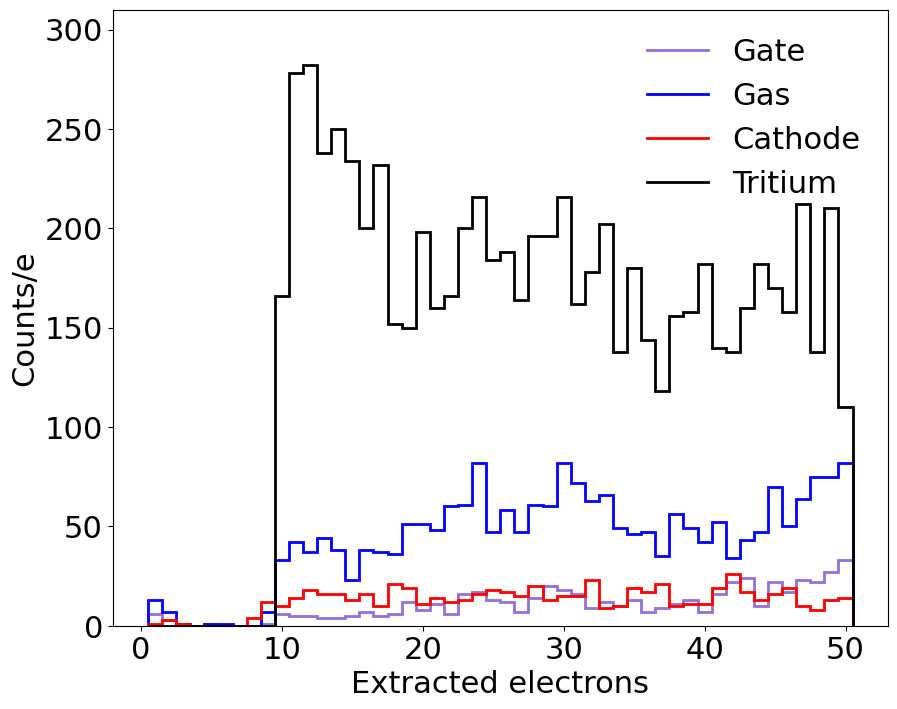

In [30]:
gate_hist = Hist(electron_axis)
gate_cut = df.type == "gate"
gate_hist.fill(df.ext_elec[gate_cut])

gas_hist = Hist(electron_axis)
gas_cut = df.type == "gas"
gas_hist.fill(df.ext_elec[gas_cut])

cath_hist = Hist(electron_axis)
cath_cut = df.type == "cath"
cath_hist.fill(df.ext_elec[cath_cut])

trit_hist = Hist(electron_axis)
trit_cut = df.type == "Tritium"
trit_hist.fill(df.ext_elec[trit_cut])

fig, ax = plt.subplots(figsize=(10, 8))
gate_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
gas_hist.plot(color='blue',ls='-',lw=2,yerr=False,label='Gas',ax=ax)
cath_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
trit_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)
plt.ylim(0, 310)
ax.set(xlabel='Extracted electrons',ylabel='Counts/e')
ax.legend(loc='upper right',frameon=False)

plt.show()

In [69]:
weight_list = []

for ii in range(0, df.shape[0]):
    if df.type[ii] == 'gate':
        index = np.searchsorted(gate_hist.to_numpy()[1],df.ext_elec[ii]) - 1
        bin_counts = gate_hist.to_numpy()[1][index]
    elif df.type[ii] == 'gas':
        index = np.searchsorted(gas_hist.to_numpy()[1],df.ext_elec[ii]) - 1
        bin_counts = gas_hist.to_numpy()[1][index]
    elif df.type[ii] == 'cath':
        index = np.searchsorted(cath_hist.to_numpy()[1],df.ext_elec[ii]) - 1
        bin_counts = cath_hist.to_numpy()[1][index]
    elif df.type[ii] == 'Tritium':
        index = np.searchsorted(trit_hist.to_numpy()[1],df.ext_elec[ii]) - 1
        bin_counts = trit_hist.to_numpy()[1][index]     
    weight_list.append(1/bin_counts)
        
df['weights'] = weight_list

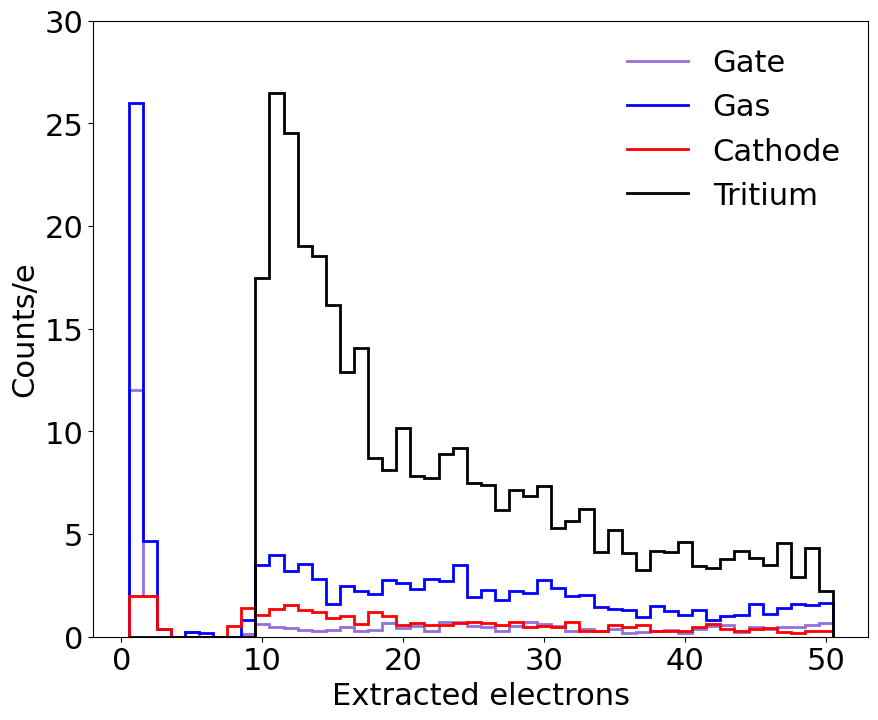

In [77]:
norm_gate_hist = Hist(electron_axis)
gate_cut = df.type == "gate"
norm_gate_hist.fill(df.ext_elec[gate_cut],weight = df.weights[gate_cut])

norm_gas_hist = Hist(electron_axis)
gas_cut = df.type == "gas"
norm_gas_hist.fill(df.ext_elec[gas_cut],weight = df.weights[gas_cut])

norm_cath_hist = Hist(electron_axis)
cath_cut = df.type == "cath"
norm_cath_hist.fill(df.ext_elec[cath_cut],weight = df.weights[cath_cut])

norm_trit_hist = Hist(electron_axis)
trit_cut = df.type == "Tritium"
norm_trit_hist.fill(df.ext_elec[trit_cut],weight = df.weights[trit_cut])

fig, ax = plt.subplots(figsize=(10, 8))
norm_gate_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
norm_gas_hist.plot(color='blue',ls='-',lw=2,yerr=False,label='Gas',ax=ax)
norm_cath_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
norm_trit_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)

ax.set(xlabel='Extracted electrons',ylabel='Counts/e',ylim=[0,30])
ax.legend(loc='upper right',frameon=False)

plt.show()

# Machine learning

### Prepare data for machine learning

In [80]:
df_ML = df[df.ext_elec > ana_thresh_e]#.loc[:,features]

df_ML.keys()

Index(['target', 'type', 'runID', 'evtID', 'S2_area', 'S2_btm_area',
       'S2_top_area', 'S2_TBA', 'S2_corrected_area', 'S2_XY_corrected_area',
       'S2_width_ns', 'S2_peakAmp', 'S2_AFT_5', 'S2_AFT_10', 'S2_AFT_25',
       'S2_AFT_50', 'S2_AFT_75', 'S2_AFT_90', 'S2_AFT_95', 'S2_rmsWidth_ns',
       'S2_fwhm_ns', 'S2_x_cm', 'S2_y_cm', 'S2_xy_chiSq', 'S2_n_saturated',
       'has_good_S1', 'drift_time', 'S1_area', 'S1_corrected_area',
       'evt_total_area', 'evt_bad_area', 'evt_bad_e_area', 'evt_bad_ph_area',
       'evt_bad_oth_area', '10_5', '25_10', '50_25', '75_50', '90_75', '95_90',
       'ext_elec', 'weights'],
      dtype='object')

In [83]:
features = ['S2_peakAmp','10_5','25_10','50_25', \
            '75_50','90_75','95_90', 'ext_elec']

X = df_ML[features]
Y = df_ML['target']
T = df_ML['type']
W = df_ML['weights']
A = df_ML['S2_top_area'] + df_ML['S2_btm_area']
R = ((df_ML['S2_x_cm'])**2 + (df_ML['S2_y_cm'])**2)**0.5
X_raw = df_ML['S2_x_cm']
Y_raw = df_ML['S2_y_cm']
#L = df_ML['luxstamp']
X_train_unscaled, X_test_unscaled, \
Y_train, Y_test, \
A_train, A_test, \
W_train, W_test, \
T_train, T_test, \
R_train, R_test, \
X_raw_train, X_raw_test, \
Y_raw_train, Y_raw_test = train_test_split(X, Y, A, W, T, R, X_raw, Y_raw, random_state=0)

In [84]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_unscaled.astype('float64'))
X_test = scaler.transform(X_test_unscaled.astype('float64'))

### Adaptively boosted decision tree

In [93]:
DTC = DecisionTreeClassifier(max_depth=2,min_samples_split=2)
ABC = AdaBoostClassifier(base_estimator=DTC,n_estimators=100,algorithm = 'SAMME')
model = ABC.fit(X_train, Y_train.values.ravel()
                ,sample_weight=W_train.values.ravel().astype('float64'))

Y_score = model.decision_function(X_test)

model.score(X_train, Y_train, sample_weight=W_train.astype('float64')), \
model.score(X_test, Y_test, sample_weight=W_test.astype('float64')) 

/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


(0.7793425008544564, 0.7761453755943641)

# Understanding machine learning

# Results

In [89]:
FPR, TPR, TH = roc_curve(Y_test,Y_score,sample_weight = W_test,pos_label = 2)

/Users/trinitystenhouse/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


In [90]:
TH

array([ 1.60860697,  0.60860697,  0.59965649, ..., -0.58775015,
       -0.58790214, -0.6535325 ])

In [91]:
TPR

array([nan, nan, nan, ..., nan, nan, nan])

In [92]:
Y_score

array([ 0.23178099, -0.03438415,  0.03464888, ...,  0.08705253,
       -0.42861878,  0.37778808])